In [1]:
import urllib
import requests
from IPython.core.display import HTML
def css_styling():
    styles = requests.get('https://raw.githubusercontent.com/saadtony/NumericalMethods/master/styles/custom.css')
    return HTML(styles.text)
css_styling()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
%matplotlib inline
%config InlineBackend.figure_format='svg'
plt.rcParams['animation.html'] = 'html5'

In [52]:
# Define helper functions to compute the divergences in the Navier-Stokes equations
def ddxc(f, dx):
    '''
    Function to compute the first derivative in the x-direction using a centered-difference on f
    '''
    result = np.zeros_like(f)
    result[1:-1,1:-1] = (f[1:-1,2:]-f[1:-1,:-2])/2./dx
    return result

def ddyc(f, dy):
    '''
    Function to compute the first derivative in the y-direction using a centered-difference on f
    '''
    result = np.zeros_like(f)
    result[1:-1,1:-1] = (f[2:,1:-1]-f[:-2,1:-1])/2./dy
    return result

def laplacian(f, dx, dy):
    '''
    Function to compute the laplacian using a centered-difference on f
    '''
    result = np.zeros_like(f)
    result[1:-1,1:-1] = (f[2:,1:-1]-2*f[1:-1,1:-1]+f[:-2,1:-1])/dy/dy + (f[1:-1,2:]-2*f[1:-1,1:-1]+f[1:-1,:-2])/dx/dx
    return result

def div(u, v, dx, dy):
    '''
    Function to compute the divergence of the supplied vectors
    '''
    return ddxc(u, dx) + ddyc(v, dy)

In [58]:
def pressure_poisson(p, dx, dy, b):
    pn = np.empty_like(p)
    it = 0
    err = 1e5
    tol = 1e-3
    maxit = 50
    while it < maxit and err > tol:
        pn = np.copy(p)
        # Explicit solution for the diagonal terms
        p[1:-1,1:-1] = (((pn[1:-1,2:]+pn[1:-1,:-2])*dy**2 + 
                        (pn[2:,1:-1]+pn[:-2,1:-1])*dx**2) /
                        (2*(dx**2 + dy**2)) -
                        dx**2 * dy**2/(2*(dx**2 + dy**2)) * b[1:-1,1:-1])
        
        # Set boundary conditions every iteration. One of the pressure values must be fixed for a unique solution
        ## dp/dx = 0 at x = 0
        p[:,0] = p[:,1]
        ## dp/dx = 0 at x = L
        p[:,-1] = p[:,-2]
        ## dp/dy = 0 at y = 0
        p[0,:] = p[1,:]
        ## p = 0 at the outlet
        p[:,-1] = 0.
        ## dp/dx = 0 at y = L
        p[-1,:] = p[-2,:]
        ## Set pressure at inlet to be greater than atmospheric
        p[ny//2-5:ny//2+5,0] = 10.
        err = np.linalg.norm(p - pn, 2)
        it += 1
        
        
    #print(f'Pressure convergence after {it} steps, error norm = {err:0.3f}')
    return p

In [62]:
# Define the physical domain and other parameters
nx = 32
ny = 32
Lx = 1.
Ly = 1.
ν = 0.05
dx = Lx/(nx-1)
dy = Ly/(ny-1)
Ut = 2.   # Top boundary velocity
# dt = min(0.25*dx*dx/ν, 4.*ν/Ut/Ut)
dt = 1e-3

u = np.zeros((ny,nx))
v = np.zeros((ny,nx))
p = np.zeros((ny,nx))
print(f'Re: {Ut*Lx/ν:0.2f}')

Re: 40.00


In [63]:
t = 0.
tend = 100 * dt
## MAIN LOOP ##
while t < tend:
    # Set boundary conditions
    ## Inlet conditions
    u[:,0] = 0.                 # u = 0 at x = 0
    u[0,:] = 0.                 # u = 0 at y = 0 (no outflow through top)
    u[:,-1] = u[:,-2]           # du/dx = 0 at x = Lx
    u[-1,:] = 0.                # u = 0 at y = Ly
    u[ny//2-5:ny//2+5,0] = 2.  # Inlet flow
    
    ## y-velocity flow at boundaries
    v[:,0] = 0.    # Left wall
    v[:,-1] = 0.   # Right wall
    v[-1,:] = 0.   # Top wall
    v[0,:] = 0.    # Bottom wall
    
    ## Create an obstacle
    u[ny//2-5:ny//2+5, nx//3-5:nx//3+5] = 0.
    v[ny//2-5:ny//2+5, nx//3-5:nx//3+5] = 0.
    
    # x-momentum RHS
    ## u rhs: -d(uu)/dx - d(uv)/dy + ν*d2(x)
    urhs = -ddxc(u*u, dx) - ddyc(u*v, dy) + ν*laplacian(u, dx, dy)
    # y-momentum RHS
    ## v rhs: -d(vu)/dx - d(vv)/dy + ν*d2(x) 
    vrhs = -ddxc(v*u, dx) - ddyc(v*v, dy) + ν*laplacian(v, dx, dy)
    
    # Calculate the intermediate velocities
    uh = u + dt*urhs
    vh = v + dt*vrhs
    
    # pressure poisson rhs: div(uh)/dt
    prhs = div(uh,vh,dx,dy)/dt
    p = pressure_poisson(p, dx, dy, prhs)
    
    # Compute true velocities
    ## u_{n+1} = uh - dt*dp/dx
    u = uh - dt*ddxc(p,dx)
    v = vh - dt*ddyc(p,dy)
    
    t += dt

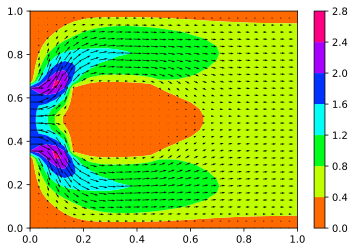

In [64]:
vel = np.sqrt(u**2 + v**2)
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
plt.contourf(x, y, vel, cmap='hsv')
plt.colorbar()
plt.quiver(x,y,u,v)

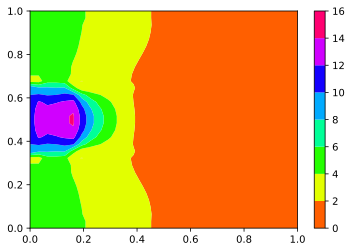

In [68]:
dpx = ddxc(p,dx)
dpy = ddyc(p,dy)
plt.contourf(x,y,p,cmap='hsv')
#plt.quiver(x,y,dpx,dpy)
plt.colorbar()